Introduction to K-Nearest Neighbors

While AirBnB doesn't release any data on the listings in their marketplace, a separate group named [Inside AirBnB](http://insideairbnb.com/get-the-data.html) has extracted data on a sample of the listings for many of the major cities on the website. In this post, we'll be working with their dataset from October 3, 2015 on the listings from Washington, D.C., the capital of the United States. Here's a direct [link](http://data.insideairbnb.com/united-states/dc/washington-dc/2015-10-03/data/listings.csv.gz) to that dataset. Each row in the dataset is a specific listing that's available for renting on AirBnB in the Washington, D.C. area.

To make the dataset less cumbersome to work with, we've removed many of the columns in the original dataset and renamed the file to `dc_airbnb.csv`. Here are the columns we kept:

 - `host_response_rate`: the response rate of the host
 - `host_acceptance_rate`: number of requests to the host that convert to rentals
 - `host_listings_count`: number of other listings the host has
 - `latitude`: latitude dimension of the geographic coordinates
 - `longitude`: longitude part of the coordinates
 - `city`: the city the living space resides
 - `zipcode`: the zip code the living space resides
 - `state`: the state the living space resides
 - `accommodates`: the number of guests the rental can accommodate
 - `room_type`: the type of living space (Private room, Shared room or Entire home/apt
 - `bedrooms`: number of bedrooms included in the rental
 - `bathrooms`: number of bathrooms included in the rental
 - `beds`: number of beds included in the rental
 - `price`: nightly price for the rental
 - `cleaning_fee`: additional fee used for cleaning the living space after the guest leaves
 - `security_deposit`: refundable security deposit, in case of damages
 - `minimum_nights`: minimum number of nights a guest can stay for the rental
 - `maximum_nights`: maximum number of nights a guest can stay for the rental
 - `number_of_reviews`: number of reviews that previous guests have left

Let's read the dataset into Pandas and become more familiar with it.

In [10]:
import pandas as pd
dc_listings = pd.read_csv('dc_airbnb.csv')
print(dc_listings.iloc[0])

host_response_rate                  92%
host_acceptance_rate                91%
host_listings_count                  26
accommodates                          4
room_type               Entire home/apt
bedrooms                              1
bathrooms                             1
beds                                  2
price                           $160.00
cleaning_fee                    $115.00
security_deposit                $100.00
minimum_nights                        1
maximum_nights                     1125
number_of_reviews                     0
latitude                          38.89
longitude                      -77.0028
city                         Washington
zipcode                           20003
state                                DC
Name: 0, dtype: object


Here's the strategy we wanted to use:

 - Find a few similar listings.
 - Calculate the average nightly rental price of these listings.
 - Set the average price as the price for our listing.

The `k-nearest neighbors` algorithm is similar to this strategy.

Euclidean distance

The Euclidean distance between the first row in the dc_listings Dataframe and our own living space is 1. How do we know if this is high or low? If you look at the Euclidean distance equation itself, the lowest value you can achieve is 0. This happens when the value for the feature is exactly the same for both observations you're comparing.

In [11]:
import numpy as np
our_acc_value = 3
first_living_space_value = dc_listings.iloc[0]['accommodates']
first_distance = np.abs(first_living_space_value - our_acc_value)
print(first_distance)

1


In [12]:
# Calculate distances for all observations

new_listing = 3
dc_listings['distance'] = dc_listings['accommodates'].apply(lambda x: np.abs(x - new_listing))
print(dc_listings['distance'].value_counts())

1     2294
2      503
0      461
3      279
5       73
4       35
7       22
6       17
9       12
13       8
8        7
12       6
11       4
10       2
Name: distance, dtype: int64


In [13]:
# Randomizing and sorting

np.random.seed(1)
dc_listings = dc_listings.loc[np.random.permutation(len(dc_listings))]
dc_listings = dc_listings.sort_values('distance')
print(dc_listings.iloc[0:10]['price'])

577     $185.00
2166    $180.00
3631    $175.00
71      $128.00
1011    $115.00
380     $219.00
943     $125.00
3107    $250.00
1499     $94.00
625     $150.00
Name: price, dtype: object


Before we can select the 5 most similar living spaces and compute the average price, we need to clean the price column. 

Right now, the price column contains comma characters (,) and dollar sign characters and is formatted as a text column instead of a numeric one. 

We need to remove these values and convert the entire column to the float datatype. Then, we can calculate the average price.

In [14]:
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')
mean_price = dc_listings.iloc[0:5]['price'].mean()
print(mean_price)

156.6


In [15]:
# Make predictions

# Brought along the changes we made to the `dc_listings` Dataframe.
dc_listings = pd.read_csv('dc_airbnb.csv')
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')
dc_listings = dc_listings.loc[np.random.permutation(len(dc_listings))]

def predict_price(new_listing):
    temp_df = dc_listings.copy()
    temp_df['distance'] = temp_df['accommodates'].apply(lambda x: np.abs(x - new_listing))
    temp_df = temp_df.sort_values('distance')
    nearest_neighbors = temp_df.iloc[0:5]['price']
    predicted_price = nearest_neighbors.mean()
    return(predicted_price)

acc_one = predict_price(1)
acc_two = predict_price(2)
acc_four = predict_price(4)

print(acc_one)
print(acc_two)
print(acc_four)

71.8
96.8
96.0


### Evaluating Model Performance

We now have a function that can predict the price for any living space we want to list as long as we know the number of people it can accommodate. The function we wrote represents a machine learning model, which means that it outputs a prediction based on the input to the model.

A simple way to test the quality of your model is to:

 - split the dataset into 2 partitions:

   - the training set: contains the majority of the rows (75%)
   - the test set: contains the remaining minority of the rows (25%)

 - use the rows in the training set to predict the price value for the rows in the test set

 - add new column named predicted_price to the test set
 
 - compare the predicted_price values with the actual price values in the test set to see how accurate the predicted values were.
 
This validation process, where we use the training set to make predictions and the test set to predict values for, is known as train/test validation.

In [16]:
dc_listings = pd.read_csv("dc_airbnb.csv")
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')
train_df = dc_listings.iloc[0:2792]
test_df = dc_listings.iloc[2792:]

def predict_price(new_listing):
    ## DataFrame.copy() performs a deep copy
    temp_df = train_df.copy()
    temp_df['distance'] = temp_df['accommodates'].apply(lambda x: np.abs(x - new_listing))
    temp_df = temp_df.sort_values('distance')
    nearest_neighbor_prices = temp_df.iloc[0:5]['price']
    predicted_price = nearest_neighbor_prices.mean()
    return(predicted_price)

test_df['predicted_price'] = test_df['accommodates'].apply(predict_price)

/Users/otto/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


We now need a metric that quantifies how good the predictions were on the test set. This class of metrics is called an error metric. 

As the name suggests, an error metric quantifies how inaccurate our predictions were from the actual values. In our case, the error metric tells us how off our predicted price values were from the actual price values for the living spaces in the test dataset.

mean absolute error

In [17]:
# Mean Absolute Error
test_df['error'] = np.absolute(test_df['predicted_price'] - test_df['price'])
mae = test_df['error'].mean()
print(mae)

56.29001074113876


/Users/otto/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
# Mean Squared Error
test_df['squared_error'] = (test_df['predicted_price'] - test_df['price'])**(2)
mse = test_df['squared_error'].mean()
print(mse)

18646.525370569325


/Users/otto/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


The model we trained achieved a mean squared error of around 18646.5. Is this a high or a low mean squared error value? What does this tell us about the quality of the predictions and the model? By itself, the mean squared error value for a single model isn't all that useful.

The units of mean squared error in our case is dollars squared (not dollars), which makes it hard to reason about intuitively as well. We can, however, train another model and then compare the mean squared error values to see which model performs better on a relative basis. Recall that a low error metric means that the gap between the predicted list price and actual list price values is low while a high error metric means the gap is high.

Let's train another model, this time using the `bathrooms` column, and compare MSE values.

In [19]:
train_df = dc_listings.iloc[0:2792]
test_df = dc_listings.iloc[2792:]

def predict_price(new_listing):
    temp_df = train_df.copy()
    temp_df['distance'] = temp_df['bathrooms'].apply(lambda x: np.abs(x - new_listing))
    temp_df = temp_df.sort_values('distance')
    nearest_neighbors_prices = temp_df.iloc[0:5]['price']
    predicted_price = nearest_neighbors_prices.mean()
    return(predicted_price)

test_df['predicted_price'] = test_df['bathrooms'].apply(lambda x: predict_price(x))
test_df['squared_error'] = (test_df['predicted_price'] - test_df['price'])**(2)
mse = test_df['squared_error'].mean()
print(mse)

18405.444081632548


/Users/otto/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/otto/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [20]:
# Root Mean Squared Error

rmse = mse ** (1/2)
print(rmse)

135.6666653295221


In [21]:
# Comparing RMSE and MAE

errors_one = pd.Series([5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10])
errors_two = pd.Series([5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 1000])
mae_one = errors_one.sum()/len(errors_one)
rmse_one = np.sqrt((errors_one**2).sum()/len(errors_one))
print(mae_one)
print(rmse_one)

mae_two = errors_two.sum()/len(errors_two)
rmse_two = np.sqrt((errors_two**2).sum()/len(errors_two))
print(mae_two)
print(rmse_two)

7.5
7.905694150420948
62.5
235.82302686548658


#### Multivariate K-Nearest Neighbors



In [22]:
np.random.seed(1)

dc_listings = pd.read_csv('dc_airbnb.csv')
dc_listings = dc_listings.loc[np.random.permutation(len(dc_listings))]
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')
print(dc_listings.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3723 entries, 574 to 1061
Data columns (total 19 columns):
host_response_rate      3289 non-null object
host_acceptance_rate    3109 non-null object
host_listings_count     3723 non-null int64
accommodates            3723 non-null int64
room_type               3723 non-null object
bedrooms                3702 non-null float64
bathrooms               3696 non-null float64
beds                    3712 non-null float64
price                   3723 non-null float64
cleaning_fee            2335 non-null object
security_deposit        1426 non-null object
minimum_nights          3723 non-null int64
maximum_nights          3723 non-null int64
number_of_reviews       3723 non-null int64
latitude                3723 non-null float64
longitude               3723 non-null float64
city                    3723 non-null object
zipcode                 3714 non-null object
state                   3723 non-null object
dtypes: float64(6), int64(5), objec

### Removing features

The following columns contain non-numerical values:

room_type: e.g. Private room
city: e.g. Washington
state: e.g. DC
while these columns contain numerical but non-ordinal values:

latitude: e.g. 38.913458
longitude: e.g. -77.031
zipcode: e.g. 20009
Geographic values like these aren't ordinal, because a smaller numerical value doesn't directly correspond to a smaller value in a meaningful way. For example, the zip code 20009 isn't smaller or larger than the zip code 75023 and instead both are unique, identifier values. Latitude and longitude value pairs describe a point on a geographic coordinate system and different equations are used in those cases (e.g. haversine).

While we could convert the host_response_rate and host_acceptance_rate columns to be numerical (right now they're object data types and contain the % sign), these columns describe the host and not the living space itself. Since a host could have many living spaces and we don't have enough information to uniquely group living spaces to the hosts themselves, let's avoid using any columns that don't directly describe the living space or the listing itself:

host_response_rate
host_acceptance_rate
host_listings_count

Let's remove these 9 columns from the Dataframe.

In [23]:
drop_columns = ['room_type', 'city', 'state', 'latitude', 'longitude', 'zipcode', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count']
dc_listings = dc_listings.drop(drop_columns, axis=1)
print(dc_listings.isnull().sum())

accommodates            0
bedrooms               21
bathrooms              27
beds                   11
price                   0
cleaning_fee         1388
security_deposit     2297
minimum_nights          0
maximum_nights          0
number_of_reviews       0
dtype: int64


### Handling Missing Values

Of the remaining columns, 3 columns have a few missing values (less than 1% of the total number of rows):

bedrooms
bathrooms
beds
Since the number of rows containing missing values for one of these 3 columns is low, we can select and remove those rows without losing much information. There are also 2 columns that have a large number of missing values:

cleaning_fee - 37.3% of the rows
security_deposit - 61.7% of the rows
and we can't handle these easily. We can't just remove the rows containing missing values for these 2 columns because we'd miss out on the majority of the observations in the dataset. Instead, let's remove these 2 columns entirely from consideration.

In [24]:
dc_listings = dc_listings.drop(['cleaning_fee', 'security_deposit'], axis=1)
dc_listings = dc_listings.dropna(axis=0)
print(dc_listings.isnull().sum())

accommodates         0
bedrooms             0
bathrooms            0
beds                 0
price                0
minimum_nights       0
maximum_nights       0
number_of_reviews    0
dtype: int64


In [25]:
dc_listings

,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
574,2,1.0,1.0,1.0,125.0,1,4,149
1593,2,1.0,1.5,1.0,85.0,1,30,49
3091,1,1.0,0.5,1.0,50.0,1,1125,1
420,2,1.0,1.0,1.0,209.0,4,730,2
808,12,5.0,2.0,5.0,215.0,2,1825,34
...,...,...,...,...,...,...,...,...
2763,1,0.0,1.0,1.0,75.0,4,20,1
905,1,0.0,1.0,1.0,95.0,5,1125,0
1096,2,1.0,0.0,1.0,100.0,1,1125,15
235,8,2.0,1.0,4.0,194.0,1,1125,8


### Normalize columns

You may have noticed that while the accommodates, bedrooms, bathrooms, beds, and minimum_nights columns hover between 0 and 12 (at least in the first few rows), the values in the maximum_nights and number_of_reviews columns span much larger ranges. For example, the maximum_nights column has values as low as 4 and high as 1825, in the first few rows itself. If we use these 2 columns as part of a k-nearest neighbors model, these attributes could end up having an outsized effect on the distance calculations because of the largeness of the values.

For example, 2 living spaces could be identical across every attribute but be vastly different just on the maximum_nights column. If one listing had a maximum_nights value of 1825 and the other a maximum_nights value of 4, because of the way Euclidean distance is calculated, these listings would be considered very far apart because of the outsized effect the largeness of the values had on the overall Euclidean distance. To prevent any single column from having too much of an impact on the distance, we can normalize all of the columns to have a mean of 0 and a standard deviation of 1.

Normalizing the values in each column to the standard normal distribution (mean of 0, standard deviation of 1) preserves the distribution of the values in each column while aligning the scales. To normalize the values in a column to the standard normal distribution, you need to:

from each value, subtract the mean of the column
divide each value by the standard deviation of the column


In [ ]:
# Subtract each value in the column by the mean.
# first_transform = dc_listings['maximum_nights'] - dc_listings['maximum_nights'].mean()
# Divide each value in the column by the standard deviation.
# normalized_col = first_transform / first_transform.std()

# same as
# normalized_col = first_transform / dc_listings['maximum_nights'].std()

In [26]:
normalized_listings = (dc_listings - dc_listings.mean()) / (dc_listings.std())
normalized_listings['price'] = dc_listings['price']
print(normalized_listings.head(3))

      accommodates  bedrooms  bathrooms      beds  price  minimum_nights  \
574      -0.596544 -0.249467  -0.439151 -0.546858  125.0       -0.341375   
1593     -0.596544 -0.249467   0.412923 -0.546858   85.0       -0.341375   
3091     -1.095499 -0.249467  -1.291226 -0.546858   50.0       -0.341375   

      maximum_nights  number_of_reviews  
574        -0.016604           4.579650  
1593       -0.016603           1.159275  
3091       -0.016573          -0.482505  


### Euclidean distance for multivariate case



In [27]:
from scipy.spatial import distance
first_listing = normalized_listings.iloc[0][['accommodates', 'bathrooms']]
fifth_listing = normalized_listings.iloc[4][['accommodates', 'bathrooms']]
first_fifth_distance = distance.euclidean(first_listing, fifth_listing)
print(first_fifth_distance)

5.272543124668404


# Intro to scikit-learn

Scikit-learn uses a similar object-oriented style to Matplotlib and you need to instantiate an empty model first by calling the constructor:

from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
If you refer to the documentation, you'll notice that by default:

n_neighbors: the number of neighbors, is set to 5
algorithm: for computing nearest neighbors, is set to auto
p: set to 2, corresponding to Euclidean distance
Let's set the algorithm parameter to brute and leave the n_neighbors value as 5, which matches the implementation we wrote in the last mission. If we leave the algorithm parameter set to the default value of auto, scikit-learn will try to use tree-based optimizations to improve performance (which are outside of the scope of this mission):

In [28]:
from sklearn.neighbors import KNeighborsRegressor

train_df = normalized_listings.iloc[0:2792]
test_df = normalized_listings.iloc[2792:]
train_columns = ['accommodates', 'bathrooms']

# Instantiate ML model.
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute')

# Fit model to data.
knn.fit(train_df[train_columns], train_df['price'])

# Use model to make predictions.
predictions = knn.predict(test_df[train_columns])

In [30]:
# MSE with sklearn
from sklearn.metrics import mean_squared_error

two_features_mse = mean_squared_error(test_df['price'], predictions)
two_features_rmse = two_features_mse ** (1/2)
print(two_features_mse)
print(two_features_rmse)

15600.51385665529
124.90201702396679


In [31]:
# Using more features

features = ['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews']
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute')

knn.fit(train_df[features], train_df['price'])
four_predictions = knn.predict(test_df[features])
four_mse = mean_squared_error(test_df['price'], four_predictions)
four_rmse = four_mse ** (1/2)
print(four_mse)
print(four_rmse)

13322.432400455064
115.42284176217056


In [32]:
# Use all features

knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute')

features = train_df.columns.tolist()
features.remove('price')

knn.fit(train_df[features], train_df['price'])
all_features_predictions = knn.predict(test_df[features])
all_features_mse = mean_squared_error(test_df['price'], all_features_predictions)
all_features_rmse = all_features_mse ** (1/2)
print(all_features_mse)
print(all_features_rmse)

15455.275631399316
124.31924883701363


## Hyperparameter Optimization

focus on the impact of increasing k, the number of nearby neighbors the model uses to make predictions.

varying the k value affects the behavior of the model independently of the actual data that's used when making predictions. In other words, we're impacting how the model performs without trying to change the data that's used.

In [33]:
train_df = pd.read_csv('dc_airbnb_train.csv')
test_df = pd.read_csv('dc_airbnb_test.csv')

In [34]:
train_df.head

<bound method NDFrame.head of       accommodates  bedrooms  bathrooms      beds  price  minimum_nights  \
0        -0.596544 -0.249467  -0.439151 -0.546858  125.0       -0.341375   
1        -0.596544 -0.249467   0.412923 -0.546858   85.0       -0.341375   
2        -1.095499 -0.249467  -1.291226 -0.546858   50.0       -0.341375   
3        -0.596544 -0.249467  -0.439151 -0.546858  209.0        0.487635   
4         4.393004  4.507903   1.264998  2.829956  215.0       -0.065038   
...            ...       ...        ...       ...    ...             ...   
2787     -1.095499 -1.438810  -0.439151 -0.546858   83.0       -0.341375   
2788      0.401366 -0.249467  -0.439151  0.297345  109.0       -0.065038   
2789     -0.596544 -0.249467   1.264998 -0.546858   90.0       -0.341375   
2790     -0.596544 -0.249467  -0.439151 -0.546858  108.0       -0.341375   
2791     -0.596544 -0.249467  -0.439151 -0.546858   79.0       -0.341375   

      maximum_nights  number_of_reviews  
0          -0.0

In [35]:
features = ['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews']
hyper_params = [1, 2, 3, 4, 5]
mse_values = list()

for hp in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=hp, algorithm='brute')
    knn.fit(train_df[features], train_df['price'])
    predictions = knn.predict(test_df[features])
    mse = mean_squared_error(test_df['price'], predictions)
    mse_values.append(mse)

print(mse_values)

[26364.92832764505, 15100.52246871445, 14579.597901655923, 16212.300767918088, 14090.011649601822]


In [37]:
#  k value of 20

features = ['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews']
hyper_params = [x for x in range(1, 21)]
mse_values = list()

for hp in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=hp, algorithm='brute')
    knn.fit(train_df[features], train_df['price'])
    predictions = knn.predict(test_df[features])
    mse = mean_squared_error(test_df['price'], predictions)
    mse_values.append(mse)
print(mse_values)

[26364.92832764505, 15100.52246871445, 14579.597901655923, 16212.300767918088, 14090.011649601822, 13657.290671217292, 14288.273896589353, 14853.448183304892, 14670.831907751512, 14642.451478953355, 14734.071380889252, 14854.556669510808, 14733.16190399257, 14777.975894453346, 14771.124646694478, 14870.178509847838, 14832.598509630716, 14783.592968300116, 14775.594716988267, 14676.947986348125]


As we increased the k value from 1 to 6, the MSE value decreased from approximately 26364 to approximately 13657. However, as we increased the k value from 7 to 20, the MSE value didn't decrease further but instead hovered between approximately 14288 and 14870. This means that the optimal k value is 6, since it resulted in the lowest MSE value.

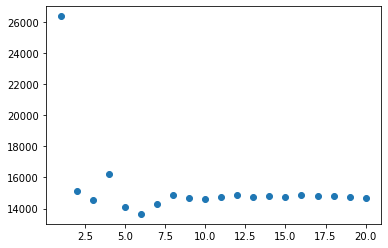

In [38]:
import matplotlib.pyplot as plt
plt.scatter(hyper_params, mse_values)
plt.show()

From the scatter plot, you can tell that the lowest MSE value was achieved at the k value of 6. As we increased k past 6, the MSE actually increased and hovered but never decreased below 13657 (the approximate MSE value when k was 6).

Since varying the k value decreased the MSE value for this model, you may be wondering if repeating the grid search process for one of the models from the last mission that performed poorly when we fixed k to 5 would result in a lower MSE value.

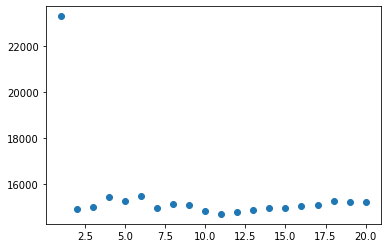

In [39]:
hyper_params = [x for x in range(1,21)]
mse_values = list()

features = train_df.columns.tolist()
features.remove('price')

for hp in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=hp, algorithm='brute')
    knn.fit(train_df[features], train_df['price'])
    predictions = knn.predict(test_df[features])
    mse = mean_squared_error(test_df['price'], predictions)
    mse_values.append(mse)

plt.scatter(hyper_params, mse_values)
plt.show()

#### The general workflow for finding the best model is:

- select relevant features to use for predicting the target column.
 - use grid search to find the optimal hyperparameter value for the selected features.
 - evaluate the model's accuracy and repeat the process.

Let's now practice this workflow.

In [40]:
two_features = ['accommodates', 'bathrooms']
three_features = ['accommodates', 'bathrooms', 'bedrooms']
hyper_params = [x for x in range(1,21)]
# Append the first model's MSE values to this list.
two_mse_values = list()
# Append the second model's MSE values to this list.
three_mse_values = list()
two_hyp_mse = dict()
three_hyp_mse = dict()

for hp in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=hp, algorithm='brute')
    knn.fit(train_df[two_features], train_df['price'])
    predictions = knn.predict(test_df[two_features])
    mse = mean_squared_error(test_df['price'], predictions)
    two_mse_values.append(mse)

two_lowest_mse = two_mse_values[0]
two_lowest_k = 1

for k,mse in enumerate(two_mse_values):
    if mse < two_lowest_mse:
        two_lowest_mse = mse
        two_lowest_k = k + 1
    
for hp in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=hp, algorithm='brute')
    knn.fit(train_df[three_features], train_df['price'])
    predictions = knn.predict(test_df[three_features])
    mse = mean_squared_error(test_df['price'], predictions)
    three_mse_values.append(mse)
    
three_lowest_mse = three_mse_values[0]
three_lowest_k = 1

for k,mse in enumerate(three_mse_values):
    if mse < three_lowest_mse:
        three_lowest_mse = mse
        three_lowest_k = k + 1

two_hyp_mse[two_lowest_k] = two_lowest_mse
three_hyp_mse[three_lowest_k] = three_lowest_mse

print(two_hyp_mse)
print(three_hyp_mse)

{5: 14790.314266211606}
{7: 13518.769009310208}
